In [2]:
import itertools as it
import qutip as qt
import numpy as np

from typing import Optional

In [3]:
def disconnectivity_info(fair_sampling_gs: qt.Qobj , N: int):    
    out_obj  = {}
    min_delta_m = 100
    min_delta_m_info = []

    ent_cache = {}

    for bp_size in range(2,N + 1):
        out_obj[bp_size] = []


        

        for bp in list(it.combinations(range(N), bp_size)):
            bp_obj = {}

            bp_obj["bp"] = list(bp)

            bp_obj["s_m"] = round(qt.entropy_vn(fair_sampling_gs.ptrace(list(bp))),5)
            ent_cache[bp] = bp_obj["s_m"]
            
            min_sub_m_ent = 100000
            min_sub_m_bp = []
            for s_bp_size in range(1,bp_size):
                for sbp in list(it.combinations(list(bp), s_bp_size)):
                    if sbp in ent_cache:
                        sub_m_ent = round(2*ent_cache[sbp],5)
                    else:
                        sub_m_ent = round(2*qt.entropy_vn(fair_sampling_gs.ptrace(list(sbp))),5)
                    if sub_m_ent < min_sub_m_ent:
                        min_sub_m_ent = sub_m_ent
                        min_sub_m_bp = list(sbp)

            bp_obj["min_sub_bp"] = min_sub_m_bp
            bp_obj["min_sub_s"] = min_sub_m_ent
            
            delta_m = bp_obj["s_m"]/bp_obj["min_sub_s"] if bp_obj["min_sub_s"] != 0 else 1
                

            
            bp_obj["delta_m"] = delta_m

            if delta_m < min_delta_m:
                min_delta_m = delta_m
                min_delta_m_info = [bp_obj]
            elif delta_m == min_delta_m:
                min_delta_m_info.append(bp_obj)

            out_obj[bp_size].append(bp_obj)


    return out_obj


def disconnectivity(fair_sampling_gs: qt.Qobj , N: int) -> int:    


    disconnectivity = 0
    min_delta_m = 100
    min_bp = []
    ent_cache = {}

    for bp_size in range(2,N + 1):
        for bp in list(it.combinations(range(N), bp_size)):

            S_bp = round(qt.entropy_vn(fair_sampling_gs.ptrace(list(bp))),5)
            ent_cache[bp] = S_bp
            
            min_S_sub_bp = 100000
            for sub_bp_size in range(1,bp_size):
                for sub_bp in list(it.combinations(list(bp), sub_bp_size)):
                    if sub_bp in ent_cache:
                        S_sub_bp = round(2*ent_cache[sub_bp],5)
                    else:
                        S_sub_bp = round(2*qt.entropy_vn(fair_sampling_gs.ptrace(list(sub_bp))),5)
                    if S_sub_bp < 1e-5:
                        min_S_sub_bp = 0
                        break
                    if S_sub_bp < min_S_sub_bp:
                        min_S_sub_bp = S_sub_bp



            delta_m = S_bp / min_S_sub_bp if min_S_sub_bp != 0 else 1

            if delta_m < 1 and delta_m <= min_delta_m:
                min_delta_m = delta_m
                disconnectivity = bp_size
                min_bp = bp


    # print(min_bp)
    # print(min_delta_m)

    return disconnectivity


def build_qobj_gs(ground_states: list, N: int, gs_prob_amps: Optional[list] = None) -> qt.Qobj:

    full_q_gs = np.zeros([2**N, 1])

    if gs_prob_amps:        
        for i,gs in enumerate(ground_states):
            full_q_gs[i] = np.sqrt(gs_prob_amps[i])
    else:
        norm_factor = 1/np.sqrt(len(ground_states))
        for gs in ground_states:
            full_q_gs[gs] = norm_factor


    return qt.Qobj(full_q_gs, dims = [[2 for _ in range(N)], [1 for _ in range(N)]])

def decimal_to_spin_state(decimal_state: int, N: int) -> str:
    unicode_map = {"0": "\u2191", "1": "\u2193"}
    return "".join([unicode_map[c] for c in bin(decimal_state)[2:].zfill(N)])


In [24]:
N = 8

reduced_gs = [16, 49, 81, 97, 109, 117, 138, 146, 158, 174, 206, 239]
# reduced_gs = [9,30]

fair_sampling_gs = np.zeros([2**N,1])
gs_size = len(reduced_gs)

for g in reduced_gs:
    print(decimal_to_spin_state(g, N))
    fair_sampling_gs[g] = 1/np.sqrt(gs_size)


# fair_sampling_gs = qt.Qobj(fair_sampling_gs, dims = [[2 for i in range(N)], [1 for i in range(N)]])


# disc = disconnectivity(fair_sampling_gs , N)
# print(disc)

↑↑↑↓↑↑↑↑
↑↑↓↓↑↑↑↓
↑↓↑↓↑↑↑↓
↑↓↓↑↑↑↑↓
↑↓↓↑↓↓↑↓
↑↓↓↓↑↓↑↓
↓↑↑↑↓↑↓↑
↓↑↑↓↑↑↓↑
↓↑↑↓↓↓↓↑
↓↑↓↑↓↓↓↑
↓↓↑↑↓↓↓↑
↓↓↓↑↓↓↓↓


In [105]:
import os
os.chdir('/Users/asherlantz/Desktop/physics/FairSampling')

import data_service
from database.models import InstancesN8
from tqdm import tqdm

fair_discs = []
pa_discs = []

N = 8
with data_service.get_session() as session:
    instances: list[InstancesN8] = (
        session.query(InstancesN8).where(InstancesN8.degeneracy > 2).all()
    )

    for instance in tqdm(instances):
        fair_discs.append(disconnectivity(build_qobj_gs(instance.reduced_gs, N), N))
        pa_discs.append(disconnectivity(build_qobj_gs(instance.reduced_gs, N, instance.post_anneal_gs_probs), N))
    


100%|██████████| 2851/2851 [27:24<00:00,  1.73it/s]


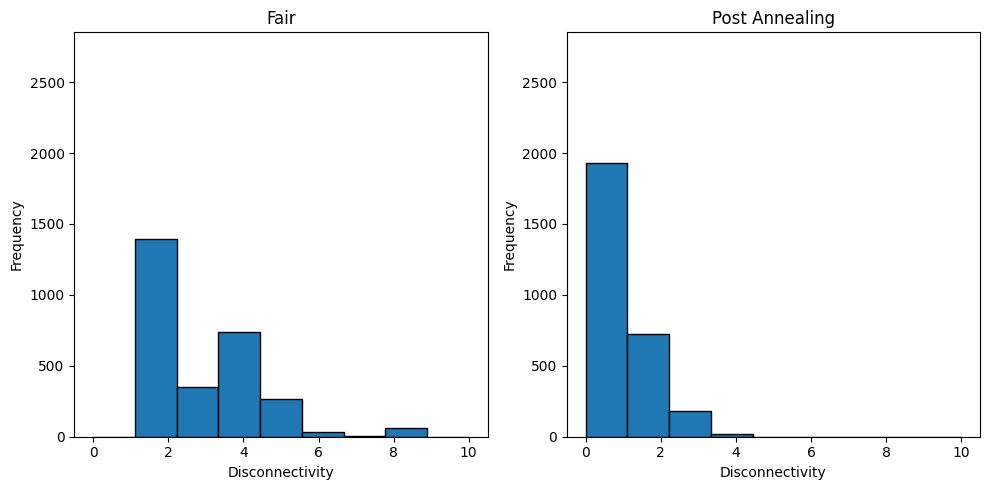

In [106]:
import matplotlib.pyplot as plt


y_limits = (0, len(fair_discs)) 


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create the first histogram
ax1.hist(fair_discs, bins=9, range = [0,10], edgecolor='black')
ax1.set_title('Fair')
ax1.set_xlabel('Disconnectivity')
ax1.set_ylabel('Frequency')
ax1.set_ylim(y_limits)

# Create the second histogram
ax2.hist(pa_discs, bins=9, range = [0,10], edgecolor='black')
ax2.set_title('Post Annealing')
ax2.set_xlabel('Disconnectivity')
ax2.set_ylabel('Frequency')
ax2.set_ylim(y_limits)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


In [100]:
fair_discs[54]

8

In [102]:
import os
os.chdir('/Users/asherlantz/Desktop/physics/FairSampling')

import data_service
from database.models import InstancesN8
from tqdm import tqdm

N = 8
with data_service.get_session() as session:
    instances: list[InstancesN8] = (
        session.query(InstancesN8).where(InstancesN8.seed == 192).all()
    )

    for instance in instances:
        print(disconnectivity(build_qobj_gs(instance.reduced_gs, N), N))
        print(disconnectivity(build_qobj_gs(instance.reduced_gs, N, instance.post_anneal_gs_probs), N))

8
3


In [1]:
import os
os.chdir('/Users/asherlantz/Desktop/physics/FairSampling')

from tfim_sk_infd.models.IsingBasis import IsingBasis
import tfim_sk_infd.services.entropy_service as tfe

N=8
basis = IsingBasis(N)
A = np.array([0,1,2,3])
B = np.array([4,5,6,7])
# v = build_qobj_gs([94, 103, 110, 117, 127, 128, 138, 145, 152, 161],N).full().T[0]
v = np.full(2**N, 1e-10)
gs = [94, 103, 110, 117, 127, 128, 138, 145, 152, 161]
norm_factor = 1/np.sqrt(len(gs))
for g in gs:
    v[g] = norm_factor
S = tfe.get_svd(basis,A,B,v)

ent = tfe.entropy(S)

ent

NameError: name 'np' is not defined

In [21]:
N = 8

# psi0 = np.full(2**N, 1e-5)
psi0 = np.zeros(2**N)
pa_gs_Amps = [0.49999968442437287, 0.4999996844643138]
# pa_gs_Amps = [0.5,0.5]
# gs = [94, 103, 110, 117, 127, 128, 138, 145, 152, 161]
gs = [9,30]

# gs = [788, 1436]

for i,g in enumerate(gs):
    psi0[g] = np.sqrt(pa_gs_Amps[i])

disconnectivity = 0
min_delta_m = 10000
min_bp = []
ent_cache = {():0, tuple([i for i in range(N)]): 0}

min_deltas = {}

basis = IsingBasis(N)
spin_set = set([i for i in range(N)])

for bp_size in range(2,N):
    for bp in list(it.combinations(range(N), bp_size)):
        if bp in ent_cache:
            S_bp = ent_cache[bp]
        else:
            bp_A = np.array(bp)
            bp_B = np.array(list(spin_set - set(bp)))
            S_bp = tfe.entropy_zeros(tfe.get_svd(basis, bp_A, bp_B, psi0 ))
            ent_cache[tuple(bp_A)] = ent_cache[tuple(bp_B)] = S_bp
        
        
        min_S_sub_bp = 100000
        sub_spin_set = set(bp)
        for sub_bp_size in range(1,bp_size):
            for sub_bp_n in list(it.combinations(list(bp), sub_bp_size)):
                

                # Partition n
                if sub_bp_n in ent_cache:
                    S_bp_n = ent_cache[tuple(sub_bp_n)]
                else:
                    bp_A_n = np.array(sub_bp_n)
                    bp_B_n = np.array(list(spin_set - set(sub_bp_n)))
                    S_bp_n = tfe.entropy_zeros(tfe.get_svd(basis, bp_A_n, bp_B_n, psi0 ))
                    ent_cache[tuple(bp_A_n)] = ent_cache[tuple(bp_B_n)] = S_bp_n

                # Partition M-n
                sub_bp_Mn = sub_spin_set - set(sub_bp_n)
                if tuple(sub_bp_Mn) in ent_cache:
                    S_bp_Mn = ent_cache[tuple(sub_bp_Mn)]
                else:
                    bp_A_Mn = np.array(list(sub_bp_Mn))
                    bp_B_Mn = np.array(list(spin_set - sub_bp_Mn))
                    S_bp_Mn = tfe.entropy_zeros(tfe.get_svd(basis, bp_A_Mn, bp_B_Mn, psi0 ))
                    ent_cache[tuple(bp_A_Mn)] = ent_cache[tuple(bp_B_Mn)] = S_bp_Mn


                
                if S_bp_n + S_bp_Mn < min_S_sub_bp:
                    min_S_sub_bp = S_bp_n + S_bp_Mn



        delta_m = S_bp / min_S_sub_bp if min_S_sub_bp != 0 else 1

        if delta_m <= min_delta_m:
            min_delta_m = delta_m
            min_bp = bp
    min_deltas[bp_size] = min_delta_m
    min_delta_m = 100000


# print(min_bp)
# print(min_delta_m)

min_deltas

{2: 0.5,
 3: 0.5,
 4: 4.5525031013917113e-07,
 5: 0.49999999991204225,
 6: 0.5,
 7: 0.5}

In [144]:
ent_cache

{(): 0,
 (0, 1, 2, 3, 4, 5, 6, 7): 0,
 (0, 1): 7.593627662532022e-17,
 (2, 3, 4, 5, 6, 7): 7.593627662532022e-17,
 (0,): 5.193142912635905e-17,
 (1, 2, 3, 4, 5, 6, 7): 5.193142912635905e-17,
 (1,): 5.193142912635905e-17,
 (0, 2, 3, 4, 5, 6, 7): 5.193142912635905e-17,
 (0, 2): 7.593627662532022e-17,
 (1, 3, 4, 5, 6, 7): 7.593627662532022e-17,
 (2,): 5.193142912635905e-17,
 (0, 1, 3, 4, 5, 6, 7): 5.193142912635905e-17,
 (0, 3): 0.6931471805599454,
 (1, 2, 4, 5, 6, 7): 0.6931471805599454,
 (3,): 0.6931471805599454,
 (0, 1, 2, 4, 5, 6, 7): 0.6931471805599454,
 (0, 4): -3.6815293677015426e-16,
 (1, 2, 3, 5, 6, 7): -3.6815293677015426e-16,
 (4,): -5.277139092428059e-15,
 (0, 1, 2, 3, 5, 6, 7): -5.277139092428059e-15,
 (0, 5): 0.6931471805599454,
 (1, 2, 3, 4, 6, 7): 0.6931471805599454,
 (5,): 0.6931471805599454,
 (0, 1, 2, 3, 4, 6, 7): 0.6931471805599454,
 (0, 6): 0.6931471805599454,
 (1, 2, 3, 4, 5, 7): 0.6931471805599454,
 (6,): 0.6931471805599454,
 (0, 1, 2, 3, 4, 5, 7): 0.693147180559945

In [118]:
psi0 = np.full(2**N, 1e-10)
gs = [94, 103, 110, 117, 127, 128, 138, 145, 152, 161]
norm_factor = 1/np.sqrt(len(gs))
for g in gs:
    psi0[g] = norm_factor

dims_A , dims_B = 4,4
M = psi0.reshape(dims_A, dims_B)
M

ValueError: cannot reshape array of size 256 into shape (4,4)

TypeError: unhashable type: 'set'

In [136]:
ent_cache[tuple([])]

0

In [11]:

N = 8

basis = IsingBasis(N)

# psi0 = np.full(2**N, 1e-3)
psi0 = np.zeros(2**N)
# gs = [94, 103, 110, 117, 127, 128, 138, 145, 152, 161]
gs = [9,30]
norm_factor = 1/np.sqrt(len(gs))
for g in gs:
    psi0[g] = norm_factor

bp_A = np.array([0, 1, 2, 4])
bp_B = np.array([3, 5, 6, 7])

# [0 1 2 4]
# [3 5 6 7]



print(tfe.get_svd(basis, bp_A, bp_B, psi0 ))
S = tfe.get_svd(basis, bp_A, bp_B, psi0 )
print(np.where(S == 0, 0, S**2 * np.log(S**2)))
S_bp = tfe.entropy_zeros(S)
S_bp

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/var/folders/84/h0vjvdyd5jsfdwfh08421q980000gn/T/ipykernel_40499/495979685.py:23: RuntimeWarning: divide by zero encountered in log
  print(np.where(S == 0, 0, S**2 * np.log(S**2)))
/var/folders/84/h0vjvdyd5jsfdwfh08421q980000gn/T/ipykernel_40499/495979685.py:23: RuntimeWarning: invalid value encountered in multiply
  print(np.where(S == 0, 0, S**2 * np.log(S**2)))


-0.0

In [53]:
# Reduce hilbert space
from tfim_sk_infd.models.IsingBasis import IsingBasis
from scipy import linalg

N = 8
gs = [9,30]
v = [np.sqrt(1/2),np.sqrt(1/2)]

gs_bin = np.array([np.array([int(bit) for bit in bin(g)[2:].zfill(8)]) for g in gs])

A = np.array([0,1,2,3])
B = np.array([4,5,6,7])

a_space = np.array(list({int("".join(state[A].astype(str)), 2) for state in gs_bin}))
b_space = np.array(list({int("".join(state[B].astype(str)), 2) for state in gs_bin}))
psiMat = np.zeros([len(a_space), len(b_space)])
for i,state in enumerate(gs_bin):
    a_state = int("".join(state[A].astype(str)), 2)
    b_state = int("".join(state[B].astype(str)), 2)
    a_index = np.where(a_space == a_state)[0][0]
    b_index = np.where(b_space == b_state)[0][0]
    psiMat[a_index, b_index] = v[i]
S = linalg.svd(psiMat, compute_uv=False)
S

array([0.70710678, 0.70710678])

In [48]:
gs = [9,30]

A = np.array( [0,1,2,4])
B = np.array( [3,5,6,7])

a_set = set()
b_set = set()


for g in gs:
    bin_array = np.array([int(bit) for bit in bin(g)[2:].zfill(8)])

    print(bin_array)
    print(bin_array[A])
    print(bin_array[B])




[0 0 0 0 1 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1 1 1 1 0]
[0 0 0 1]
[1 1 1 0]


[[0.7071067811865476, 0], [0, 0.7071067811865476]]

In [39]:
np.array([np.array([int(bit) for bit in bin(g)[2:].zfill(8)]) for g in gs])

array([[0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 1, 1, 0]])

In [11]:
import os
os.chdir('/Users/asherlantz/Desktop/physics/FairSampling')

import tfim_sk_infd.services.entropy_service as tfe
import numpy as np
import itertools as it

def disconnectivity(gs_amps: np.ndarray, ground_states: np.ndarray, N: int):

    disconnectivity_dict= {1: 0.0}
    
    ent_cache = {tuple([i for i in range(N)]): 0, (): 0}
    spin_set = set([i for i in range(N)])

    for bp_size in range(2, N+1):

        min_delta_m = 1000
        for bp in list(it.combinations(range(N), bp_size)):

            if bp in ent_cache:
                S_bp = ent_cache[bp]
            else:
                bp_A = np.array(bp)
                bp_B = np.array(list(spin_set - set(bp)))
                S_bp = tfe.entropy_zeros(
                    tfe.get_svd_reduced(ground_states, bp_A, bp_B, gs_amps, N)
                )
                ent_cache[tuple(bp_A)] = ent_cache[tuple(bp_B)] = S_bp

            min_S_sub_bp = 100000
            sub_spin_set = set(bp)
            for sub_bp_size in range(1, bp_size):
                for sub_bp_n in list(it.combinations(list(bp), sub_bp_size)):

                    # Partition n
                    if sub_bp_n in ent_cache:
                        S_bp_n = ent_cache[tuple(sub_bp_n)]
                    else:
                        bp_A_n = np.array(sub_bp_n)
                        bp_B_n = np.array(list(spin_set - set(sub_bp_n)))
                        S_bp_n = tfe.entropy_zeros(
                            tfe.get_svd_reduced(
                                ground_states, bp_A_n, bp_B_n, gs_amps, N
                            )
                        )
                        ent_cache[tuple(bp_A_n)] = ent_cache[tuple(bp_B_n)] = S_bp_n

                    # Partition M-n
                    sub_bp_Mn = sub_spin_set - set(sub_bp_n)
                    if tuple(sub_bp_Mn) in ent_cache:
                        S_bp_Mn = ent_cache[tuple(sub_bp_Mn)]
                    else:
                        bp_A_Mn = np.array(list(sub_bp_Mn))
                        bp_B_Mn = np.array(list(spin_set - sub_bp_Mn))
                        S_bp_Mn = tfe.entropy_zeros(
                            tfe.get_svd_reduced(
                                ground_states, bp_A_Mn, bp_B_Mn, gs_amps, N
                            )
                        )
                        ent_cache[tuple(bp_A_Mn)] = ent_cache[tuple(bp_B_Mn)] = S_bp_Mn

                    if S_bp_n + S_bp_Mn < min_S_sub_bp:
                        min_S_sub_bp = S_bp_n + S_bp_Mn

            delta_m = S_bp / min_S_sub_bp if min_S_sub_bp != 0 else 1

            if delta_m <= min_delta_m:
                min_delta_m = delta_m
                # disconnectivity_dict[bp_size] = [min_delta_m, S_bp, min_S_sub_bp]
                disconnectivity_dict[bp_size] = min_delta_m
    return disconnectivity_dict

N = 12
# ground_states = [313, 2345]

ground_states = [1323, 1659, 2747]
# gs_amps = [np.sqrt(1/len(ground_states)) for _ in ground_states]
# gs_amps = [6.382701056368955e-09, 0.9999118511893355]
# gs_amps = np.sqrt([0.08435076924703958, 0.06798989901623977, 0.30268088336786364, 0.0797135176370938, 0.10744685908934498, 0.19347139165009708, 0.16401456725231908])
# gs_amps = np.sqrt([0.4999342523352538, 0.4999311910652837])
# gs_amps = np.sqrt([0.024474511814828785, 0.4247289314340026, 0.5507246019908497])
# gs_amps = np.sqrt([0,1/2,1/2])
gs_amps = np.sqrt([ 1/2, 1/2, 0])
# gs_amps = np.sqrt([0.499 ,0.499])



print(np.linalg.norm(gs_amps))
gs_amps /= np.linalg.norm(gs_amps)
print(np.linalg.norm(gs_amps))
print( "gs_amps", gs_amps)

disc = disconnectivity(gs_amps, ground_states, N)
disc

1.0
1.0
gs_amps [0.70710678 0.70710678 0.        ]


{1: 0.0,
 2: 0.5,
 3: 0.5,
 4: -0.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1,
 11: 1,
 12: 1}